In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from collections import Counter
from matplotlib.font_manager import FontProperties
font_set= FontProperties(fname='/home/kesci/input/work1730/SourceHanSerifCN-Light-5.otf',size=12)
colors = ['#CCFF99','#99FF33','#BBFFEE','#33FFAA','#77FFEE','#00FFCC','#CCEEFF','#33CCFF','#CCDDFF','#99BBFF','#5599FF','#9999FF','#5555FF','#DDDDDD']

# 忽略警告信息
import warnings
warnings.filterwarnings("ignore")

print("建立开发环境"+ str(datetime.now()) )
# 读取投中数据 
df_gs = pd.read_csv('/home/kesci/input/inv_data6040/01_工商信息.csv')
df_ry = pd.read_csv('/home/kesci/input/inv_data6040/02_主要人员.csv')
df_tz = pd.read_csv('/home/kesci/input/inv_data6040/03_投融资事件.csv')
df_td = pd.read_csv('/home/kesci/input/inv_data6040/核心团队.csv')
df_listed = pd.read_csv('/home/kesci/input/work1730/集成电路A股数据.csv')

一、集成电路领域创投业务解读
集成电路是我国政府近年来重点发展的产业，行业从研发到销售盈利的周期较长且需要大量资金投入。很多初创企业的资金需求主要靠创投机构支持，并带动股权融资、企业债券、银行、信托等金融机构贷款等社会融资，促进集成电路资金链、创新链、产业链的结合。由于投资周期较长，而国内很多私募股权投资基金期限较短导致投资机构有快速退出的压力，2019年上交所推出的科创板重点关注芯片设计、半导体制造等硬科技行业，利于资本的退出，从而利于资本涌向科技创新。同时，政府也陆续出台了一系列支持集成电路产业发展的政策，设立集成电路产业投资基金,并且在一期投完之后紧接着进行二期的投资，打通产业链实现国产替代不被卡脖子。

集成电路产业链涉及芯片设计、制造、封装、测试、装备与材料等环节。通常来说创投机构倾向投资芯片设计企业，而产业的基础设施部分回报率低或周期很长，适合由政府大基金投入建设。我们可以深入分析集成电路企业的工商信息、人员构成、投融资信息、企业经营状况等数据，通过在时间维度和政策导向下的纵向比较，以及不同规模企业、不同地区之间的横向比较，制定多维度数据指标评定集成电路创新创业活力以及影响因子，对南京江北新区创投相关政策提供指导。

对于集成电路领域企业的甄别方式
1、首先在工商信息中筛选出制造业，集成电路隶属于制造业。
2、对于制造业当中企业简介和产业图谱描述中含有“半导体”、“芯片”、“集成电路”字样的归类为集成电路企业，在尝试筛选过程中也发现了部分生物医药的检测方面企业也有部分检测芯片业务，考虑到这种企业数量少且业务不纯，不予考虑。在筛选A股企业以及科创板相关公司时，也采取了相同的口径。

In [ ]:
# 从制造业中筛选出集成电路企业
df_gs['产业'] = df_gs['产业图谱'].copy()
df_gs.loc[ df_gs.产业.isin(['生物医药', '科技金融','生物医药 / 科技金融','科技金融 / 生物医药']) == False, '产业'] = '制造业'
df_gs.loc[ df_gs.产业.isin(['生物医药 / 科技金融','科技金融 / 生物医药']) == True, '产业'] = '科技金融'
zzy_gs = df_gs.loc[ df_gs.产业 == '制造业']
#集成电路需要是制造业里面按照企业简介寻找的，需要是企业简介包含 半导体  电路   
# 将成立时间改为时间类型
zzy_gs.成立时间 = pd.to_datetime(zzy_gs.成立时间)
# 设置为时序索引
zzy_gs.index = pd.DatetimeIndex(zzy_gs.成立时间)
# 选择出 存续、在业的企业  
zzy_gs = zzy_gs[ (zzy_gs.经营情况 == '在业') | (zzy_gs.经营情况== '存续（在营、开业、在册）') ]
#zzy_gs.经营情况.value_counts()
#zzy_gs.head(10)
bdt_list1 = zzy_gs['企业简介'].str.contains('半导体')
bdt_list2 = zzy_gs['产业图谱'].str.contains('半导体')
bdt_list = bdt_list1|bdt_list2
dl_list1 = zzy_gs['企业简介'].str.contains('电路')
dl_list2 = zzy_gs['产业图谱'].str.contains('电路')
dl_list = dl_list1|dl_list2
xp_list1 = zzy_gs['企业简介'].str.contains('芯片')
xp_list2 = zzy_gs['产业图谱'].str.contains('芯片')
xp_list = xp_list1|xp_list2
all_list = bdt_list|dl_list|xp_list
bdt = zzy_gs[bdt_list]
dl = zzy_gs[dl_list]
xp = zzy_gs[xp_list]
jcdl = zzy_gs[all_list]


二、数据清洗、数据探索、解读和可视化
1、企业注册信息
①根据工商信息，可以按时间维度得到集成电路相关制造业企业总数增长趋势，和新成立企业的注册趋势。
通过观察集成电路企业总数和新成立企业数量，可以看出新增企业注册数和相关经济事件是有关联性的。
②在资本方面，可以得到现有企业注册资本分布情况、每年新增企业注册资本、企业注册资本总值随时间变化的趋势。
现有企业注册资本主要集中在1000万到1亿之间，注册资本最大的企业在100亿左右。
通过观察集成电路新注册企业注册资本和累计注册资本，可以看出企业注册资本总量随时间不断增长，基本上是45°稳步上升的曲线，2020年仅有第一季度数据暂时先省略，这里描述现象不做季节处理。

集成电路企业总数和新成立企业数量随时间变化趋势
新成立企业数量可以比较明显地看到有三个波峰，分别是2000年、2010年和2015年。其中2000年是全球范围的互联网泡沫，相关上市公司的高估值对互联网产业链起到了一个较强的刺激，集成电路作为硬件提供方，也被互联网泡沫带动；2010年有部分后金融危机时代大水漫灌刺激的影响；2015年是大众创业万众创新的一年，并且在创业板牛市情况下新成立企业也容易获得较高的估值，因此这段时间新成立的企业多。

In [ ]:
#暂时不考虑2020年数据
jcdl1 =  jcdl.loc[ (jcdl.index.year <= 2019) ]
zs = jcdl1.groupby(jcdl1.index.year).企业名称.count().cumsum()
zsdict = {'time':zs.index,'numbers':zs.values}
df_zs = pd.DataFrame(zsdict)
df_zs['new'] = list(jcdl1.groupby(jcdl1.index.year).企业名称.count())
#设置图形大小
fig = plt.figure(figsize=(15,5))
# 按时间查看集成电路新注册企业数量
ax1 = fig.add_subplot(111)
ax1.bar(df_zs['time'], df_zs['new'],alpha=.7,color=colors,label='新增注册企业数量')
ax1.legend(loc='upper left')
ax1.set_ylabel(u'新增注册企业数量',fontproperties=font_set,fontsize='15')
ax1.set_xlabel(u'年份',fontproperties=font_set,fontsize='15')
ax1.set_title(u'集成电路企业总数和新成立企业数量',fontproperties=font_set,fontsize='20')
#查看注册企业总数量增长趋势
ax2 = ax1.twinx()  
ax2.plot(df_zs['time'], df_zs['numbers'], color='#00CED1',ms=10,label='注册企业总数量')
ax2.set_ylabel(u'注册企业总数量',fontproperties=font_set,fontsize='15')
ax2.legend(loc='upper right')
plt.show()
#df_zs

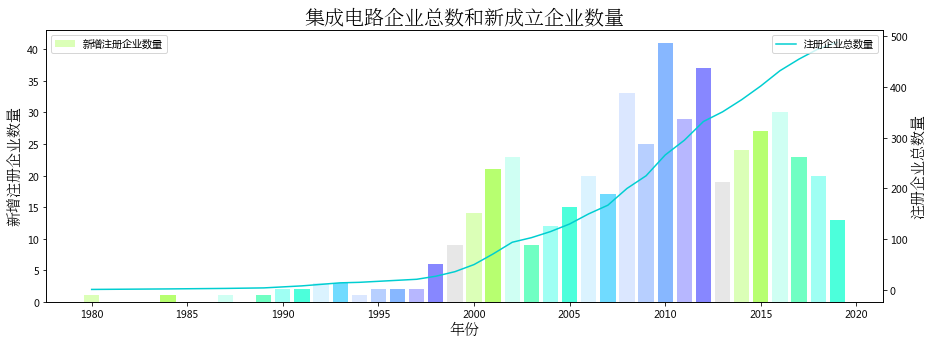

集成电路企业注册资本分布情况
由于我国集成电路产业起步较晚，因此行业中招商引资和海龟归国创业的数量不在少数，这样就有一个注册资本货币单位不统一的问题，在这里我们统一换算为人民币计价。通过以下图表可以看出，在注册资本方面，集成电路行业企业（蓝色）注册资本明显要大于其他行业企业（紫色），这也与我们的常识相符合：集成电路行业的门槛较高，具有资本密集的属性。

In [ ]:
# 统一将数据整理为 人民币 万元 
def zijin(x):
    result= 0
    if  isinstance(x, float) :
        return x
    else:
        if x.find('万元') >=0:
            result = float(x.replace('万元','')) 
        elif x.find('万美元') >=0 :
            result = float(x.replace('万美元',''))  * 7.11
        elif x.find('万日元') >=0 :
            result = float(x.replace('万日元',''))  * 0.0656
        elif x.find('万英镑') >=0 :
            result = float(x.replace('万英镑',''))  * 8.77
        elif x.find('万港元') >=0 :
            result = float(x.replace('万港元',''))  * 0.9142
        elif x.find('万欧元') >=0 :
            result = float(x.replace('万欧元',''))  * 7.6614
        else:
            x = float(x)
        return result
    
jcdl.注册资本 = jcdl.注册资本.apply(lambda x : zijin(x)  )
non_jcdl = df_gs[- df_gs['企业名称'].isin(jcdl['企业名称'])]#取不是集成电路的企业作对比
non_jcdl.注册资本 = non_jcdl.注册资本.apply(lambda x : zijin(x)  )
non_jcdl = non_jcdl.dropna(subset=['注册资本'])

# 查看注册资本数据分布情况: 取对数直方图
plt.figure(figsize=(10,5))
sns.distplot(np.log10(jcdl.注册资本),color='#00CED1', kde=False,label = '集成电路行业')
sns.distplot(np.log10(non_jcdl.注册资本),color='#99BBFF', kde=False,label = '其他行业')
plt.legend(loc='upper left')

plt.title(u'注册资本分布情况',fontproperties=font_set,fontsize='20')
plt.xlabel(u'注册资本（对数）,单位：万元',fontproperties=font_set,fontsize='15')
plt.ylabel(u'企业数量',fontproperties=font_set,fontsize='15',)

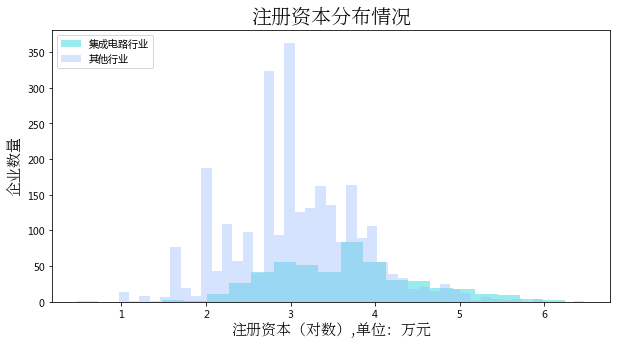

集成电路行业新增企业注册资本和累计注册资本随时间变化趋势
新增注册资本方面意义要稍弱于成立企业情况，除了一部分招投标对于注册资本有要求的行业外，很多企业并不热衷于注册资本的扩张，比如贵州茅台很多年也没有增加注册资本，江苏企业卓胜微电子也是，500多亿的市值仅有1亿的注册资本，但是仍有一定的参考意义。而且近几年政策下调公司的法定最低注册资本金，也可以看到最近几年新增企业的平均注册资本数额不大。

In [ ]:
#观察集成电路新注册企业注册资本和累计注册资本，可以看出企业注册资本总量随时间不断增长，新增企业注册资本
#在2001、2002、2006、2009、2012有明显增长。近年来大幅减少。
jcdl1 =  jcdl.loc[ (jcdl.index.year <= 2019) ]
sumzb = jcdl1.groupby(jcdl1.index.year).注册资本.sum().cumsum()
zbdict = {'time':sumzb.index,'values':sumzb.values}
df_zb = pd.DataFrame(zbdict)
df_zb['new'] = list(jcdl1.groupby(jcdl1.index.year).注册资本.sum())
df_zb['newmean'] = df_zb['new']/df_zs['new']
#设置图形大小
fig = plt.figure(figsize=(15,5))
# 按时间查看集成电路新注册企业注册资本
ax1 = fig.add_subplot(111)
ax1.bar(df_zb['time'], df_zb['new'],alpha=.7,color=colors,label='新增企业注册资本')
ax1.legend(loc='upper left')
ax1.set_ylabel(u'新增企业注册资本',fontproperties=font_set,fontsize='15')
ax1.set_xlabel(u'年份',fontproperties=font_set,fontsize='15')
ax1.set_title(u'集成电路行业新增企业注册资本和累计注册资本',fontproperties=font_set,fontsize='20')
ax1.plot(df_zb['time'], df_zb['newmean'],alpha=.7,color='#99BBFF',label='新增企业平均注册资本')
ax1.legend(loc='upper left')
#查看注册企业总数量增长趋势
#jcdl['累计注册资本'] = jcdl1.groupby(jcdl1.index.year).注册资本.sum().cumsum()
ax2 = ax1.twinx()  
ax2.plot(df_zb['time'], df_zb['values'],color='#00CED1',ms=10,label='累计注册资本')
ax2.set_ylabel(u'累计注册资本',fontproperties=font_set,fontsize='15')
ax2.legend(loc='upper right')
plt.show()

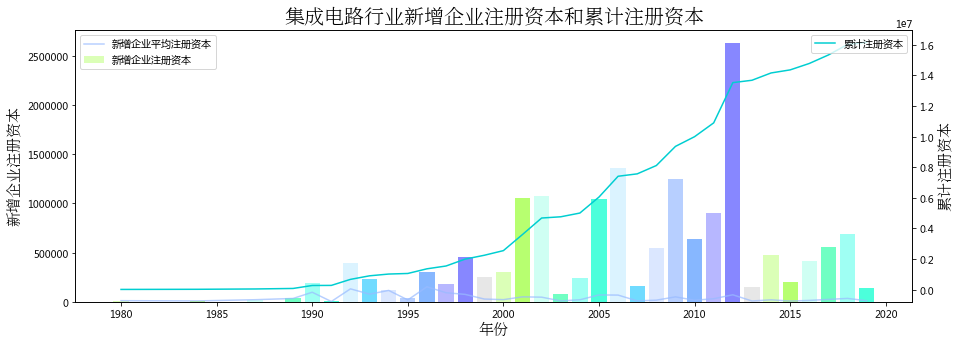

2、投融资信息
融资次数和金额
可以从两个方面统计融资活动的活跃度，一个是融资次数，另一个是融资金额。
在时间维度上，可以看出每年企业估值金额和每年投资金额在走势上趋于一致。其中2015年估值金额与融资金额比值达到最高。2009年最低。

融资轮次
在融资轮次上，可以通过工商信息表得到目前不同融资阶段的企业数量和企业估值情况：私募股权投资市场中，交易类型为非控制权收购、战略融资、控制股权收购最多；创投市场中，项目投资集中于早期的天使轮至B轮区间。
按地区维度观察，可以查看不同城市集成电路行业融资轮次分布情况，用来判断不同城市集成电路企业发展阶段和聚集度。

投资机构
找出所有投资过集成电路企业的投资机构，统计频数，找出投资次数较多的投资机构。

获投企业
找出所有被投的集成电路企业，对于这些企业的获投次数、获投金额、估值变化做一个分析，用来判断企业发展状况。
统计获投金额大于一亿和获投次数大于五次的企业，查看它们的地区分布情况，来判断不同地区企业的发展情况。

当前不同融资轮次的企业数量
集成电路企业中处于少年（天使轮）和青年（A轮）的企业较多，发展态势处于千帆竞发的阶段。
当前轮次中属于非控制权收购、战略融资、buyout(控制权收购)的也很多，这是由于行业的马太效应导致的，资源向头部企业集中，强者恒强，也是今年来经常出现的情况。

In [ ]:
# 融资情况：查看当前不同融资轮次的企业数量
fig = plt.figure(figsize=(10,6))
plt_info = jcdl.当前轮次.value_counts()
plt_info = plt_info.reindex(['种子轮', '天使轮','Pre-A','A', 'A+', 'Pre-B','B','C','D','上市及以后','非控制权收购','战略融资','Buyout','未披露'])
#print(plt_info)

plt_info.plot(kind='barh',color=colors)
plt.title(u'当前融资轮次情况',fontproperties=font_set,fontsize='20')
plt.xlabel(u'企业数量',fontproperties=font_set,fontsize='15')
plt.ylabel(u'融资轮次',fontproperties=font_set,fontsize='15')

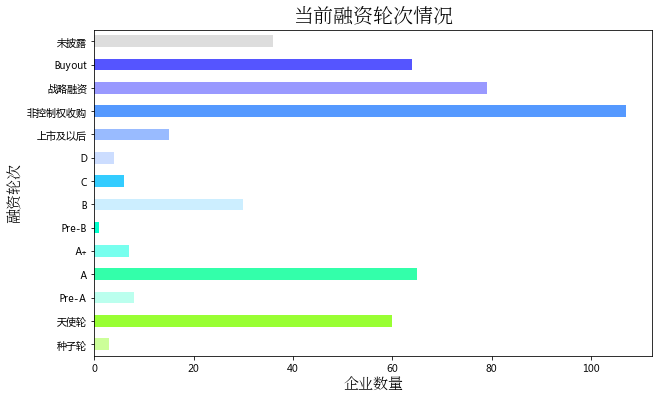

集成电路企业总融资次数和每年新增融资数随时间变化趋势
按时间分析投融资数据，过滤掉没有交易时间的数据，只删除了2000多条中的20条数据，比例可控。
融资次数和融资额可以作为新成立企业数量的补充，两个结合起来让我们更能对产业的冷热情况做一个摸底。
毕竟只有新成立企业没有老企业的融资，那么行业也是不健康的，只有做多没有做大做强那么将会是一盘散沙。可以看到不同于新成立企业数量随着年份有起伏，每年的新增融资数量基本上是按着时间顺序增长。我们可以的出结论，集成电路行业向头部企业集中的速度要大于行业的发展速度。

In [ ]:
df_tz_withtime = df_tz.dropna(subset=['交易时间'])
jcdl_qymc = jcdl['企业名称']
df_tz_jcdl = df_tz_withtime[df_tz_withtime['标的企业全称'].isin(jcdl_qymc)]#总共有496条记录
df_tz_jcdl.交易时间 = pd.to_datetime(df_tz_jcdl.交易时间)
df_tz_jcdl.index = pd.DatetimeIndex(df_tz_jcdl.交易时间)
# 按年度对比交易数量
df_tz_jcdl1 =  df_tz_jcdl.loc[(df_tz_jcdl.index.year <= 2019)]
tz = df_tz_jcdl1.groupby(df_tz_jcdl1.index.year).交易时间.count().cumsum()
tzdict = {'time':tz.index,'num':tz.values}
df_tz = pd.DataFrame(tzdict)
df_tz['new'] = list(df_tz_jcdl1.groupby(df_tz_jcdl1.index.year).交易时间.count())
#设置图形大小
fig = plt.figure(figsize=(15,5))
# 按时间查看集成电路新增投资次数
ax1 = fig.add_subplot(111)
ax1.bar(df_tz['time'], df_tz['new'],alpha=.7,color=colors,label='新增融资次数')
ax1.legend(loc='upper left')
ax1.set_ylabel(u'新增融资次数',fontproperties=font_set,fontsize='15')
ax1.set_xlabel(u'年份',fontproperties=font_set,fontsize='15')
ax1.set_title(u'集成电路企业总融资次数和每年新增融资数',fontproperties=font_set,fontsize='20')
#查看集成电路总投资次数增长趋势
ax2 = ax1.twinx()  
ax2.plot(df_tz['time'], df_tz['num'], color='#00CED1',ms=10,label='总融资次数')
ax2.set_ylabel(u'总融资次数',fontproperties=font_set,fontsize='15')
ax2.legend(loc='upper right')
plt.show()

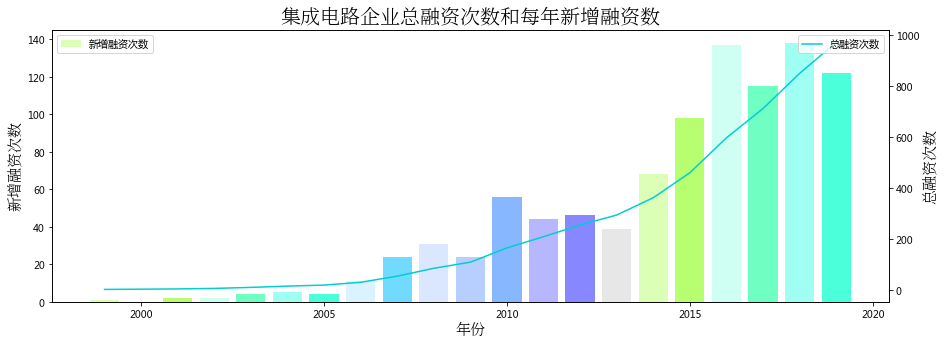

不同城市集成电路行业融资轮次分布情况¶
首先我们留意到有很多企业市级信息没有披露，但是企业名称明显有地名相关的信息，这部分信息我们可以手工完善，我们按照企业的注册地址把未披露的部分进行了细分。
很容易看出苏州的集成电路行业融资次数最多，紧随其后的是无锡、南京。江苏北部城市则相对缺乏存在感。
地区间融资轮次的占比区别不大，没有出现一些地区A轮占比特别高的情况，如果出现了某个地区天使轮、A轮比例特别高，那么可能是该地区近期有大规模集成电路企业的招商引资行为。

In [ ]:
wpl = list(df_tz_jcdl[df_tz_jcdl['市级'] == '未披露']['标的企业全称'])
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '常熟利星光电科技有限公司', '市级'] = '苏州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '江苏达伦电子股份有限公司', '市级'] = '苏州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '江苏顺风光电科技有限公司', '市级'] = '常州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '江苏宇特光电科技股份有限公司', '市级'] = '淮安市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '碳元科技股份有限公司', '市级'] = '常州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '德芯电子（昆山）有限公司', '市级'] = '苏州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '和舰芯片制造（苏州）股份有限公司', '市级'] = '苏州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '华天科技（昆山）电子有限公司', '市级'] = '苏州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '江阴新基电子设备有限公司', '市级'] = '无锡市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '快克智能装备股份有限公司', '市级'] = '常州市'
df_tz_jcdl.loc[df_tz_jcdl['标的企业全称']== '昆山龙腾光电股份有限公司', '市级'] = '苏州市'
# 查看不同城市集成电路行业融资轮次分布情况
lcarea = df_tz_jcdl[['市级','交易轮次']]
count = lcarea.groupby(['交易轮次','市级'])['交易轮次'].count().reset_index(name="Count")
pivot_count = count.pivot(index='市级', columns='交易轮次', values='Count')
pivot_count = pivot_count.fillna(0)
pivot_count['Col_sum'] = pivot_count.apply(lambda x: x.sum(), axis=1)
pivot_count = pivot_count.sort_values('Col_sum',axis = 0,ascending = False)
pivot_count = pivot_count.drop(['Col_sum'],axis=1)
colors = ['#CCFF99','#99FF33','#BBFFEE','#33FFAA','#77FFEE','#00FFCC','#CCEEFF','#33CCFF','#CCDDFF','#99BBFF','#5599FF','#9999FF','#5555FF','#DDDDDD']
pivot_count.loc[:,['Buyout', 'D', 'Pre-A', '非控制权收购', 'A+', 'C', '天使轮', 'A', 'B+', '种子轮','未披露', 'B', '战略融资', 'Pre-B']].plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.xlabel(u"城市",fontproperties=font_set,fontsize='15')
plt.ylabel(u"不同融资轮次次数",fontproperties=font_set,fontsize='15')
plt.legend()
plt.title(u'不同融资轮次地区分布情况',fontproperties=font_set,fontsize='20')

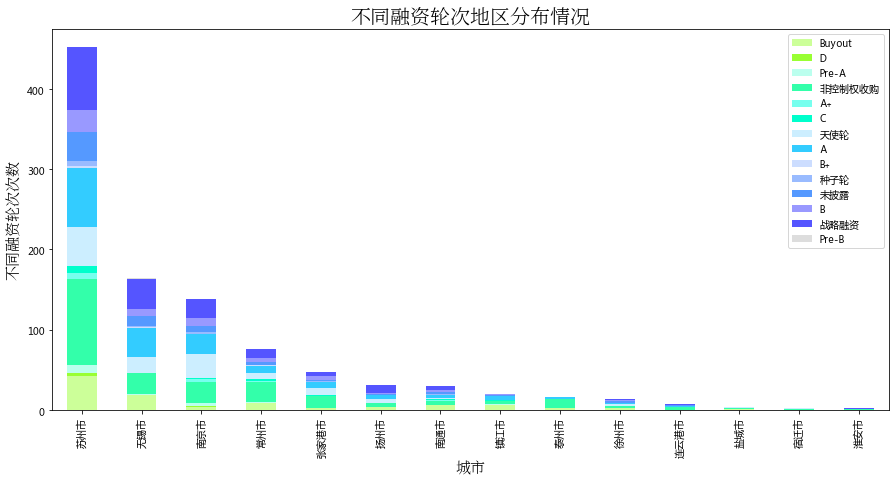

集成电路每年总交易金额和企业估值金额
可以看出交易金额和企业估值金额有明显的波峰波谷，波峰出现在09年、15年、18年，可以看出都与A股的牛市（18年是自主可控的牛市）密切相关，说明一级市场的估值和活跃度仍然深受二级市场偏好的影响。

In [ ]:
# 按年度查看交易金额和企业估值数据
# 按年度对比交易总金额
df_tz_jcdl1 = df_tz_jcdl.loc[(df_tz_jcdl.index.year <= 2019) ]
jiaoyijine = df_tz_jcdl1.groupby(df_tz_jcdl1.index.year)['总交易金额 (万元)'].sum()
jydict = {'time':jiaoyijine.index,'jyjine':jiaoyijine.values}
df_jy = pd.DataFrame(jydict)
# 按年度对比企业估值总金额
guzhijine = df_tz_jcdl1.groupby(df_tz_jcdl1.index.year)['企业估值 (万元)'].sum()
gzdict = {'time':guzhijine.index,'gzjine':guzhijine.values}
df_gz = pd.DataFrame(gzdict)
df_jine = pd.merge(df_jy,df_gz,on ='time',how = 'outer')

#按年度查看集成电路每年总交易金额和企业估值金额
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(df_jine['time'], df_jine['jyjine'],color='#00CED1',marker='o',linewidth=2,label='交易金额')
ax1.set_ylabel(u'交易总金额（万元）',fontproperties=font_set,fontsize='15')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(df_jine['time'], df_jine['gzjine'], color='#99BBFF',marker='*',linewidth=2,label='估值金额')
ax2.set_ylabel(u'估值金额（万元）',fontproperties=font_set,fontsize='15')
ax2.legend(loc='upper right')
plt.title(u'集成电路每年总交易金额和企业估值金额',fontproperties=font_set,fontsize='20')
ax1.set_xlabel(u'年份',fontproperties=font_set,fontsize='15')
plt.show()

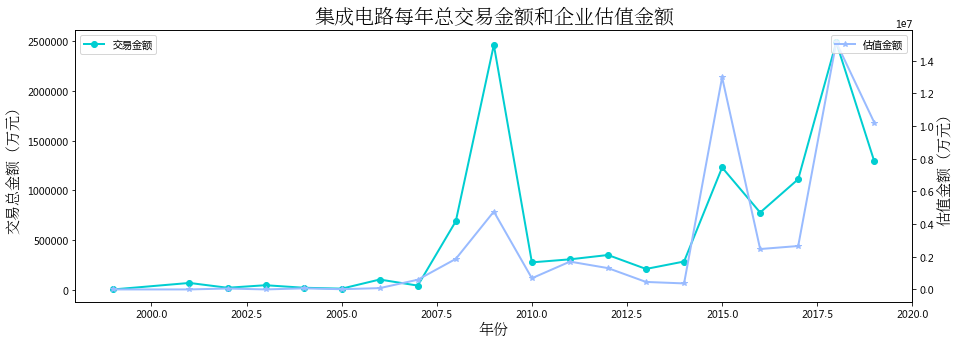

投资次数最多的投资机构
使用词云的方式找出了集成电路行业最眼熟的投资机构，第一是苏州的元禾控股、第二是无锡创投。可以看出集成电路企业和投资机构是相辅相成的关系，苏州和无锡的集成电路行业在我们上文分析的图标中经常霸榜前两名。在这里可以给出的建议是成立相关的产业扶持基金，可以极大刺激本地产业的发展。



In [ ]:
#选出投资次数最多的十家机构
touzifang = " ".join([str(x) for x in df_tz_jcdl.投资方.values])
aList = touzifang.split( )  
def get_index1(lst=None, item=''):
    return [index for (index,value) in enumerate(lst) if value == item]

indexList1 = get_index1(aList, '|')
indexList2 = get_index1(aList, 'nan')
indexList =indexList1+indexList2
aList = [aList[i] for i in range(0, len(aList), 1) if i not in indexList] 
touzifangnew = pd.DataFrame.from_dict(Counter(aList), orient='index',columns=['投资次数'])
touzifangtop = touzifangnew.sort_values(by ='投资次数',ascending = False).ix[0:10]
# 投资方词云
import wordcloud
import jieba
import collections
collections.Counter(aList).most_common(100)[0:10]
# 绘制中文词云
# 导入并初始化词云
from wordcloud import WordCloud
w = WordCloud( 
    font_path='/home/kesci/input/work1730/SourceHanSerifCN-Light-5.otf', # 字体文件路径参数
    background_color='white', # 背景色
    )
# 从词频绘制词云图片
w.generate_from_frequencies(pd.Series(aList).value_counts()[0:100])
# 绘制词云图片
plt.figure(figsize=[10,10])
plt.axis("off")
plt.imshow(w, interpolation="bilinear")
plt.show()
touzifangtop


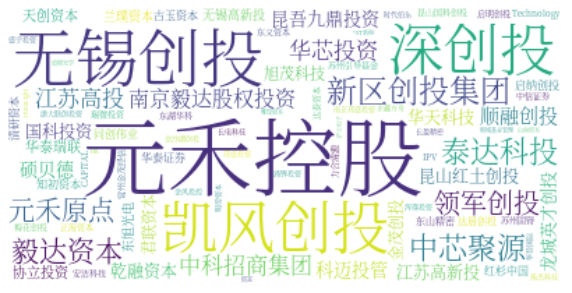

获投金额大于一亿和获投次数大于五次的企业分布地区情况
前一段我们着重分析了企业的数量，但是一个做大做强的企业带来的产业推动力要强于众多小企业，因此分析地区产业发展情况，还要看看有没有规模化的大企业产生，因此我们选取了获投金额和次数比较大的企业来分析。
从图中我们可以看到苏州遥遥领先，无锡、南京、常州作为第二梯队紧随其后，张家港由于苏州代管暂不分析，整体来说大企业的排名和之前的通过分析企业数量和融资得出的排名相似，说明各地区产业发展程度比较均衡。

In [ ]:
#查看被投方数据
df_tz_jcdl1 = df_tz_jcdl.copy()
df_tz_jcdl1.fillna(0)
jinemax = df_tz_jcdl1.loc[df_tz_jcdl1['总交易金额 (万元)']>=10000]
jinemax.sort_values(by ='总交易金额 (万元)',ascending = False)
#各个地区获得融资金额大于两亿的企业数量
city = list(jinemax.市级)
from collections import Counter
cityjine = pd.DataFrame.from_dict(Counter(city), orient='index',columns=['获投金额大于一亿企业数'])
cityjinetop = cityjine.sort_values(by ='获投金额大于一亿企业数',ascending = False).ix[0:10]
cityjinetop = cityjinetop.reset_index().rename(columns={'index':'市级'})
#获得融资次数大于五次的企业
cishu = pd.DataFrame.from_dict(Counter(df_tz_jcdl1['标的企业全称']), orient='index',columns=['获投次数'])
cishu = cishu.reset_index().rename(columns={'index':'标的企业全称'})
cishu.sort_values(by ='获投次数',ascending = False).ix[0]
#各个地区获得融资次数大于五的企业数量
cishumax = cishu.loc[cishu.获投次数>=5]
cishumax = pd.merge(cishumax,df_tz_jcdl1[['市级','标的企业全称']],on='标的企业全称',how = 'left')
city1 = list(cishumax.市级)
citycishu = pd.DataFrame.from_dict(Counter(city1), orient='index',columns=['获投次数大于五次企业数'])
citycishutop = citycishu.sort_values(by ='获投次数大于五次企业数',ascending = False)
citycishutop = citycishutop.reset_index().rename(columns={'index':'市级'})
large = pd.merge(cityjinetop, citycishutop,on='市级',how = 'outer')
large = large.fillna(0)

plt.figure(figsize=[12,6]) 
x = large['获投金额大于一亿企业数'] 
y = large['获投次数大于五次企业数'] 
colors = np.random.rand(11)
area = np.pi * (15 * np.arange(1.2,0.1,-0.1))**2 
plt.scatter(x, y, s=area, c=colors, alpha=0.5, marker='H')
#for i,txt in enumerate(large['市级']):
    #plt.annotate(txt,(x[i],y[i]))
c=large.市级
for i in range(0,len(x)):
	plt.annotate(c[i],xy=(x[i],y[i]),xytext=(x[i]+1,y[i]+1))
plt.ylabel(u'获投金额大于一亿企业数',fontproperties=font_set,fontsize='15')
plt.xlabel(u'获投次数大于五次企业数',fontproperties=font_set,fontsize='15')
plt.title(u'获投金额大于一亿和获投次数大于五次的企业分布地区',fontproperties=font_set,fontsize='20')
plt.show()

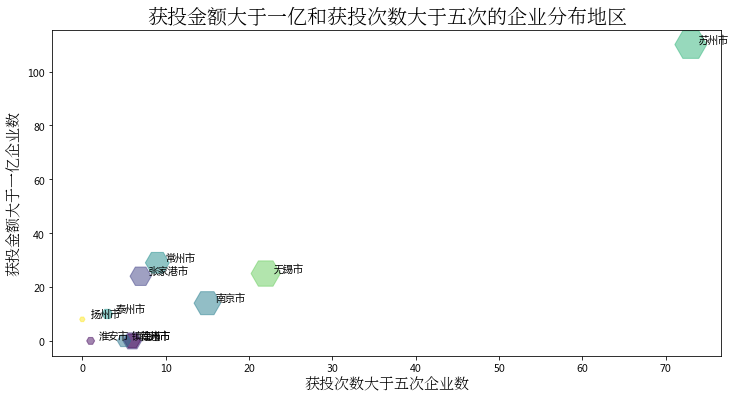

所有企业获投次数频次分布和估值变化情况
超过一半的企业融资轮次是1次，融资7次以上的企业只占4.3%，说明行业头部效应明显。
在有多轮融资的企业中，23.7%的企业估值下降，大多数企业表现较好，绝大多数企业估值上涨在一倍以内。

In [ ]:
#看看企业都展开了多少轮融资
#qiye_list = np.unique(df_tz_jcdl['标的企业全称'])
#len(qiye_list)#总共有488家企业
df_tz_jcdl['计数'] = 1
qiye_rz = df_tz_jcdl.groupby(df_tz_jcdl.标的企业全称)['计数'].sum()
qiye_rz = qiye_rz.sort_values(ascending = False)

numlist = [sum(qiye_rz == 1),sum((qiye_rz > 1) & (qiye_rz < 4)),
sum((qiye_rz >= 4) & (qiye_rz < 6)),sum(qiye_rz >= 6)]

df_tz_avg = df_tz_jcdl.dropna(subset=['企业估值 (万元)','总交易金额 (万元)'])
df_tz_avg_last = df_tz_avg.groupby(['标的企业全称']).last()['企业估值 (万元)']
df_tz_avg_first = df_tz_avg.groupby(['标的企业全称']).first()['企业估值 (万元)']
df_tz_avg_change = df_tz_avg_last / df_tz_avg_first
gzlist = [sum(df_tz_avg_change < 1),sum((df_tz_avg_change>= 1) & (df_tz_avg_change< 2)),sum((df_tz_avg_change>= 2))]


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(numlist, labels = ['1次','2到3次','4到7次','7次以上'],startangle = 90,
        colors = ['#BBFFEE','#77FFEE','#CCEEFF','#33CCFF'],autopct='%.3f%%',
        pctdistance=0.7,labeldistance=1,textprops= {'fontsize':12,'color':'black'},counterclock = False);
plt.title('企业获投次数分布情况',fontsize='15')
plt.subplot(1,2,2)
plt.pie(gzlist, labels = ['估值下降','估值上升一倍以内','估值翻倍'],startangle = 90,
        colors = ['#BBFFEE','#CCEEFF','#33CCFF'],autopct='%.3f%%',
        pctdistance=0.7,labeldistance=0.9,textprops= {'fontsize':12,'color':'black'},counterclock = False);
plt.title('企业估值变化情况',fontsize='15')
#把估值变化加入到原表中
df_tz_avg_change
changedict = {'标的企业全称':df_tz_avg_change.index,'估值变化':df_tz_avg_change.values}
df_change = pd.DataFrame(changedict)
df_tz_jcdl = pd.merge(df_tz_jcdl,df_change,on='标的企业全称',how ='outer')

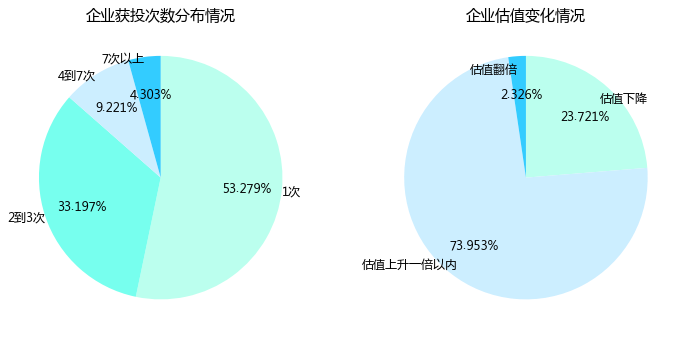

最值得投资公司
集成电路行业是资本密集型行业，启动初期需要大量的资金，有很难在短时间形成营收可以收支平衡，因此创投资金的参与对行业来说是非常必要的。那么作为创投资本来说获取收益也是天性，我们根据首轮融资和最新融资之间企业的估值变化来找出最值得投资的公司。可以看到投资增值最多的两家公司，南大光电和亚玛顿。这两个都已经在A股上市，南大光电的投资回报增加了72倍，亚玛顿增加了56倍。可以看到上市是获取投资回报收益的非常重要的手段。



In [ ]:
# 获取 '企业估值 (万元)' 不为空的数据
jcdl_tz = df_tz_jcdl
jcdl_tz = jcdl_tz[jcdl_tz['企业估值 (万元)'].isna() == False ]
# 按企业名称分组，取出最新估值
jcdl_gz = jcdl_tz.groupby(['标的企业全称']).last()['企业估值 (万元)']
# 将企业估值 与 企业信息合并
jcdl_gz = jcdl_gz.to_dict()
#df_tz_jcdl2 = df_tz_jcdl.dropna(subset = ['企业估值 (万元)'])
#df_tz_jcdl2 = df_tz_jcdl2.sort_index(axis = 0,ascending = True)
jcdl_gz1 = jcdl_tz.groupby(['标的企业全称']).first()['企业估值 (万元)']
jcdl_gz1 = jcdl_gz1.to_dict()
jcdl['最初估值'] = jcdl['企业名称'].apply(lambda x: float(jcdl_gz1[x]) if x in jcdl_gz1.keys() else 0 )
jcdl['最初估值']=jcdl['最初估值'].replace(0,np.nan)
jcdl['最新估值'] = jcdl['企业名称'].apply(lambda x: float(jcdl_gz[x]) if x in jcdl_gz.keys() else 0 )
#部分企业没有融资信息，因此估值可能有0的情况出现，剔除掉
#jcdl_ratio = jcdl[jcdl['最初估值'] > 0]

# 计算增值比例
jcdl['注册资本增值'] = jcdl.apply(lambda x: x['最新估值']/x['注册资本'], axis=1)
jcdl['投资增值'] = jcdl.apply(lambda x: (x['最新估值']-x['最初估值'])/x['最初估值'], axis=1)
# 获取增值幅度最大的企业
jcdl.sort_values(by='投资增值', ascending=False)[ ['企业名称','注册资本', '最新估值', '投资增值']].head(20) 
# 计算年均增值比例
#jcdl['成立时间'] = jcdl['成立时间'].apply(lambda x:x[0:10])
max_time = max(jcdl['成立时间'])#最大时间
a = (max_time - jcdl['成立时间'])
t=[]
for i in a:
    c =i.days/365
    t.append(c)
jcdl['经营时间']=t
jcdl['年均资本增值'] = jcdl['注册资本增值'] /jcdl['经营时间']
# 获取年均增值幅度最大的企业
jcdl.sort_values(by='投资增值', ascending=False)[ ['企业名称','注册资本','最初估值','最新估值', '经营时间','注册资本增值','投资增值','年均资本增值']].head(10)


3、商标、著作权和细分产业信息
在商标、著作权方面，根据工商信息表的相关信息，可以得到所有集成电路企业商标和著作权分布情况
在细分产业及主营业务、产品方面，根据产业图谱和企业介绍中的详细信息，可以通过云词图得到这些企业主要涉及的产品、技术以及对产业链的覆盖情况。


商标和著作权数量分布情况
商标数量明显大于著作权数量，大多数企业著作权在1个以内，商标数量在20以内。

In [ ]:
diyu = df_tz_jcdl[['标的企业全称','市级']]
diyu1= diyu.drop_duplicates(subset=None,keep='first',inplace=False)
diyu1 = diyu1.rename(columns={'标的企业全称':'企业名称'})
jcdlarea = pd.merge(jcdl, diyu1, how='left', on='企业名称')
zzsb = jcdlarea[['企业名称','市级','商标数量','著作权数量']]
a = zzsb['商标数量']
b = zzsb['著作权数量']
sblist = [sum(a < 10),sum((a>= 10) & (a< 20)),sum((a>= 20) & (a< 30)),sum((a>= 30) & (a< 40)),sum((a>= 40))]
zzlist = [sum(b<1),sum(b>=1)]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(sblist, labels = ['<10','10-20','20-30','30-40','>40'],startangle = 90,
        colors = ['#BBFFEE','#77FFEE','#CCEEFF','#33CCFF','#5555FF'],autopct='%.3f%%',
        pctdistance=1.1,labeldistance=0.8,textprops= {'fontsize':10,'color':'black'},counterclock = False);
plt.title('企业商标数量',fontsize='15')
plt.subplot(1,2,2)
plt.pie(zzlist, labels = ['=0','>=1'],startangle = 90,
        colors = ['#BBFFEE','#CCEEFF'],autopct='%.3f%%',
        pctdistance=1.1,labeldistance=0.8,textprops= {'fontsize':13,'color':'black'},counterclock = False);
plt.title('企业著作权数量',fontsize='15')

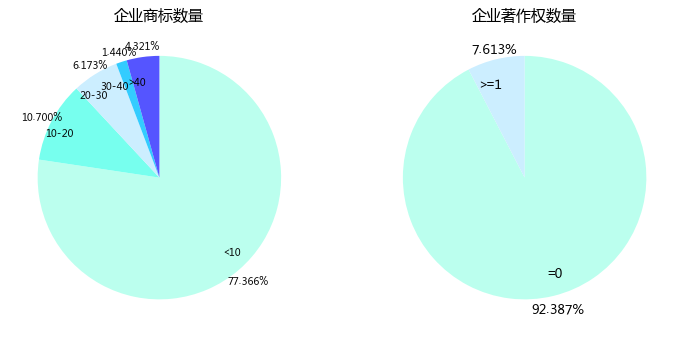

细分行业、主营业务和产品词云
出现最多的词是半导体，集成电路就是很多的半导体组合在一个电路板上，与常识相符合。
可以看出这些集成电路企业关键词涉及了设计、生产、封装、测试、材料和服务销售的全阶段。


In [ ]:
# 细分行业词云
description1 = " ".join([str(x) for x in jcdl.企业简介.values])
description2 = " ".join([str(x) for x in jcdl.产业图谱.values])
description = description1+description2
import wordcloud
import jieba
# 用 jieba 进行分词
words = list(jieba.cut(description))
# 读取停用词文件
stop_words = open('/home/kesci/input/work1730/stop_words.txt').read().split('\n')
stop_words += ['制造业','有限','公司','企业','有限公司','经营范围','领域','技术','服务','产品','国家']
# 去除停用词
words_clean = [ x for x in words if x not in stop_words]
# 去掉单个字 
words_clean = [x for x in words_clean if len(x.strip())>=2 ]
# 用 collections 计算词频
import collections
collections.Counter( words_clean).most_common(100)[0:10]
# 绘制中文词云
# 导入并初始化词云
from wordcloud import WordCloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
w = WordCloud( 
    font_path='/home/kesci/input/work1730/SourceHanSerifCN-Light-5.otf', # 字体文件路径参数
    background_color='white', 
    repeat=True, mask=mask# 背景色
    )
# 从词频绘制词云图片
w.generate_from_frequencies(pd.Series( words_clean).value_counts()[1:100])
# 绘制词云图片
plt.figure(figsize=[10,10])
plt.axis("off")
plt.imshow(w, interpolation="bilinear")
plt.show()

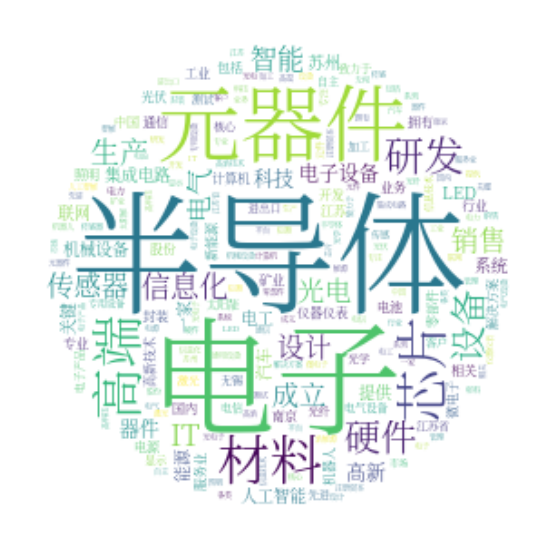

4、团队人员信息
高管团队就像古代领兵作战的将领，对于一个企业来说是非常重要的一环，也是投资机构调研企业的重要考察部分。而且集成电路行业是智力密集型行业，高学历人才对于行业发展非常重要。因此我们将从高管的个人简介中挖掘可以量化的部分进行研究。

集成电路企业高管人数和学历分布情况
我们发现部分企业可能对于核心团队的理解不同，因此对于人员上报的数量也是不同的，有一些企业只填写两个人员信息，有一些则有十多个，给我们的数据分析造成了一定的困难。整体而言，核心团队的人数大多低于15人。
我们量化的部分主要是高管的经历，评级为：千人计划>教授>博士>硕士>学士。
及评级可以看到苏州对于人才的吸引力最高。在所有人才中，千人计划是最稀缺的。

In [ ]:
# 查看核心团队数据
jcdl_td = df_td.loc[df_td.任职公司.isin(list(jcdl.企业名称)) == True]
jcdl_ry = df_ry.loc[df_ry.任职公司.isin(list(jcdl.企业名称)) == True]
# 投资数据集
jcdl_tz = df_tz_jcdl

tdnum = jcdl_td.groupby(jcdl_td.任职公司)['核心团队-人员姓名'].count()
tdnumdict = {'任职公司':tdnum.index,'核心团队人数':tdnum.values}
df_tdnum = pd.DataFrame(tdnumdict)
rynum = jcdl_ry.groupby(jcdl_ry.任职公司)['姓名'].count()
rynumdict = {'任职公司':rynum.index,'主要人员人数':rynum.values}
df_rynum = pd.DataFrame(rynumdict)
gaoguan = pd.merge(df_tdnum,df_rynum,on='任职公司',how = 'outer')
gaoguan = gaoguan.fillna(0)
t=[]
for i in range(len(gaoguan)):
    t1 = max(gaoguan.核心团队人数[i],gaoguan.主要人员人数[i])
    t.append(t1)
gaoguan['高管人数'] = t

t = gaoguan['高管人数']

gglist = [sum(t<5),sum((t>=5) & (t<10)),sum((t>=10) & (t<15)),sum(t>=15)]
plt.figure(figsize=(6,6))
plt.pie(gglist, labels = ['<5','5-10','10-15','>15'],startangle = 90,
        colors = ['#BBFFEE','#77FFEE','#CCEEFF','#33CCFF'],autopct='%.3f%%',
        pctdistance=1.1,labeldistance=0.8,textprops= {'fontsize':10,'color':'black'},counterclock = False);
plt.title('高管人数分布情况',fontsize='15')

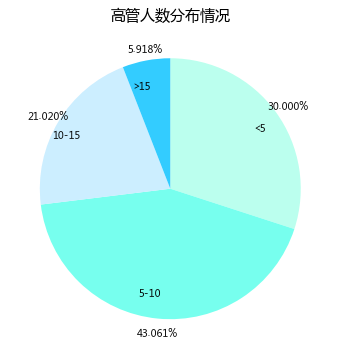

In [ ]:
#查看高管最高学历
#还要有 教授 千人计划等头衔
boshi = jcdl_td[jcdl_td['个人简介'].str.contains('博士')]
n_boshi = jcdl_td[- jcdl_td['个人简介'].str.contains('博士')]
shuoshi = n_boshi[n_boshi['个人简介'].str.contains('硕士')]
n_shuoshi = n_boshi[- n_boshi['个人简介'].str.contains('硕士')]
xueshi = n_shuoshi[n_shuoshi['个人简介'].str.contains('学士|本科')]
qianrenjihua = jcdl_td[jcdl_td['个人简介'].str.contains('千人计划')]
jiaoshou = jcdl_td[jcdl_td['个人简介'].str.contains('教授')]
boshigs = boshi.任职公司
shuoshigs = shuoshi.任职公司
xueshigs = xueshi.任职公司
qianrenjihuags = qianrenjihua.任职公司
jiaoshougs = jiaoshou.任职公司

boshinum = pd.DataFrame.from_dict(Counter(boshigs), orient='index',columns=['博士人数'])
boshinum = boshinum.reset_index().rename(columns={'index':'企业名称'})
shuoshinum = pd.DataFrame.from_dict(Counter(shuoshigs), orient='index',columns=['硕士人数'])
shuoshinum = shuoshinum.reset_index().rename(columns={'index':'企业名称'})
xueshinum = pd.DataFrame.from_dict(Counter(xueshigs), orient='index',columns=['学士人数'])
xueshinum = xueshinum.reset_index().rename(columns={'index':'企业名称'})
qianrenjihuanum = pd.DataFrame.from_dict(Counter(qianrenjihuags), orient='index',columns=['千人计划人数'])
qianrenjihuanum = qianrenjihuanum.reset_index().rename(columns={'index':'企业名称'})
jiaoshounum = pd.DataFrame.from_dict(Counter(jiaoshougs), orient='index',columns=['教授人数'])
jiaoshounum = jiaoshounum.reset_index().rename(columns={'index':'企业名称'})

df_xueli = pd.merge(boshinum,shuoshinum,on='企业名称',how='outer')
df_xueli = pd.merge(df_xueli,xueshinum,on='企业名称',how='outer')
df_xueli = pd.merge(df_xueli,qianrenjihuanum,on='企业名称',how='outer')
df_xueli = pd.merge(df_xueli,jiaoshounum,on='企业名称',how='outer')

df_xueli = df_xueli.fillna(0)
xueli = pd.merge(df_xueli,jcdl[['成立时间','企业名称','注册资本','商标数量','著作权数量']],on='企业名称',how='outer')
xueli = xueli.fillna(0)
tdnumdict1 = {'企业名称':tdnum.index,'核心团队人数':tdnum.values}
df_tdnum1 = pd.DataFrame(tdnumdict1)
xueli = pd.merge(xueli,df_tdnum1,on='企业名称',how='outer')
#xueli.sort_values(by='千人计划人数',axis=0,ascending=False)
len(xueli[xueli['千人计划人数'] > 0])#16家企业的核心团队有千人计划入选人。
len(xueli[xueli['教授人数'] > 0])#56家企业的核心团队有教授。
#可以看出教授和千人计划人数最多的是南大光电，这一开始也是南京大学的校企，产学研相结合。
#看看这个比例是否大于其他行业，如果大的话说明
xueli['博士以上比例'] = xueli['博士人数']/ xueli['核心团队人数']
xueli.sort_values(by='教授人数',axis=0,ascending=False).head(10) 

In [ ]:
# 查看不同地区高管硕博以上学历分布情况
xueliarea = pd.merge(xueli,diyu1,on='企业名称',how='left')

countboshi = xueliarea.groupby(['市级'])['博士人数'].sum()
countshuoshi = xueliarea.groupby(['市级'])['硕士人数'].sum()
#countxuesi = xueliarea.groupby(['市级'])['学士人数'].sum()
countqianren = xueliarea.groupby(['市级'])['千人计划人数'].sum()
countjiaoshou  = xueliarea.groupby(['市级'])['教授人数'].sum()
#countxueli = 
countxueli = xueliarea.groupby(['市级']).agg({'博士人数':['sum'],'硕士人数':['sum'],'千人计划人数':['sum'],'教授人数':['sum']})
#countxueli['市级'] = countxueli.index
# 重命名列名
countxueli.columns = ['博士人数','硕士人数','千人计划人数','教授人数']
countxueli = countxueli.sort_values('硕士人数',axis = 0,ascending = False)
colors = ['#CCFF99','#33FFAA','#77FFEE','#33CCFF','#5599FF']
countxueli.loc[:,['博士人数','硕士人数','千人计划人数','教授人数']].plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.xlabel(u"城市",fontproperties=font_set,fontsize='15')
plt.ylabel(u"人数",fontproperties=font_set,fontsize='15')
plt.legend()
plt.title(u'不同地区高管硕博以上学历分布情况',fontproperties=font_set,fontsize='20')

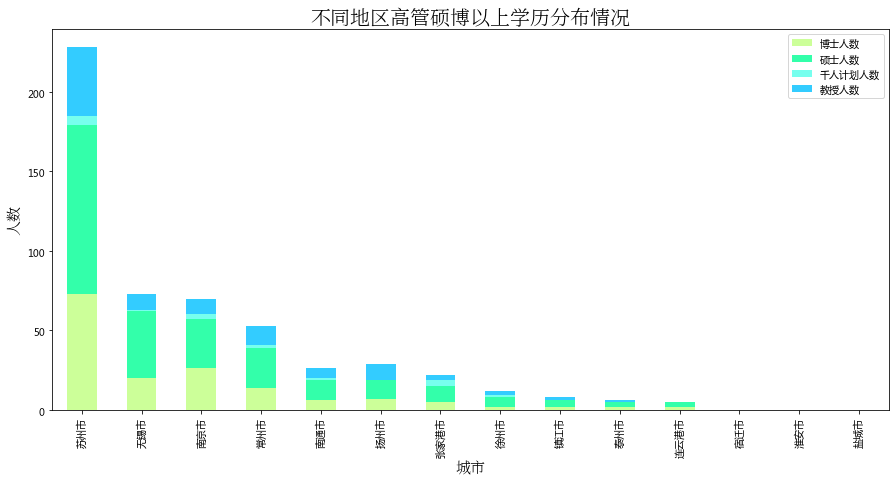

三、额外数据的获取、采用理由与分析过程
1、宏观经济数据
数据来源：国家统计局
包含2000--2019年 国民总收入(亿元)、国内生产总值(亿元)、第一产业增加值(亿元)、第二产业增加值(亿元)、第三产业增加值(亿元)、人均国内生产总值(元)、集成电路产量(万块)、基本电子电路专利申请受理量数据。其中2019年基本电子电路专利申请受理量数据缺失，为了方便分析，用近五年均值填补。因为集成电路属于第二产业，因此我们主要把第二产业增加值和集成电路发展情况作对比。

采用理由：融资活动和国家宏观经济情况紧密相关。之后可以通过回归验证创新创业活力指数受不同宏观经济指标的影响程度。

宏观经济指标增长率和热力图
可以看出国民总收入增长率、国内生产总值增长率、第二三产业增加值增长率、人均国内生产总值增长率每年波动幅度较小，集成电路产量增长率和基本电子电路专利申请受理量增长率每年波动相对较大，根据热力图可以看出有一定相关关系。

In [ ]:
eco = pd.read_csv('/home/kesci/input/work1730/统计局数据.csv')
#2019年基本电子电路专利申请受理量缺失，用近五年均值填补
eco = eco.fillna(np.mean(eco['基本电子电路专利申请受理量(项)'][1:5]))
eco = eco.drop(['第一产业增加值(亿元)','第三产业增加值(亿元)'],axis=1)
eco = eco.sort_values('年份',axis = 0,ascending = True).reset_index(drop=True)
#2000年后这些宏观经济数据分别与新注册企业量、新增注册资本、新增融资次数、新增融资金额的回归关系
#df_zs2000 = df_zs.loc[(df_zs.time >= 2000)]
rate=[]
for i in range(len(eco.columns[1:])):
    rate.append([])
    for j in range(19):
        a=(eco[eco.columns[i+1]][j+1])/(eco[eco.columns[i+1]][j])
        rate[i].append(a)
    rate[i].insert(0,1)
rate = pd.DataFrame(rate)
rate = rate.T
name = ['国民总收入增长率','国内生产总值增长率','第二产业增加值增长率','人均国内生产总值增长率','集成电路产量增长率','基本电子电路专利申请受理量增长率']
rate.columns = name
#rate['年份']=np.arange(2000,2020,1)
rate.insert(0,'年份',np.arange(2000,2020,1))
rate
#画图展示经济数据增长率(原始数据数量级不同)
fig = plt.figure(figsize=(15,10))
c= ['#33FFAA','#77FFEE','#888888','#DDDDDD','#33CCFF','#5599FF']
j = 0
for i in rate.columns[1:]:
    plt.plot(rate['年份'], rate[i],color=c[j],marker='o',linewidth=2,label=i)
    j +=1

plt.xlabel(u"年份",fontproperties=font_set,fontsize='15')
plt.ylabel(u"各指标增长率",fontproperties=font_set,fontsize='15')
plt.legend()
plt.title(u'宏观经济指标增长率',fontproperties=font_set,fontsize='20')
plt.show()
rate1 = rate[rate.columns[1:]]
eco1 = eco[eco.columns[1:]]
from sklearn.preprocessing import StandardScaler
def draw_heatmap(data):
    ylabels = data.columns.values.tolist()
    ss = StandardScaler()     # 归一化
    data = ss.fit_transform(data)
    df = pd.DataFrame(data)
    dfData = df.corr()
    plt.subplots(figsize=(9, 9)) # 设置画面大小
    ax=sns.heatmap(dfData,annot=True,vmax=1,square=True,yticklabels=ylabels,xticklabels=ylabels, cmap="GnBu")
    ax.set_ylim(7.0, 0) 
    plt.show()
draw_heatmap(rate1)

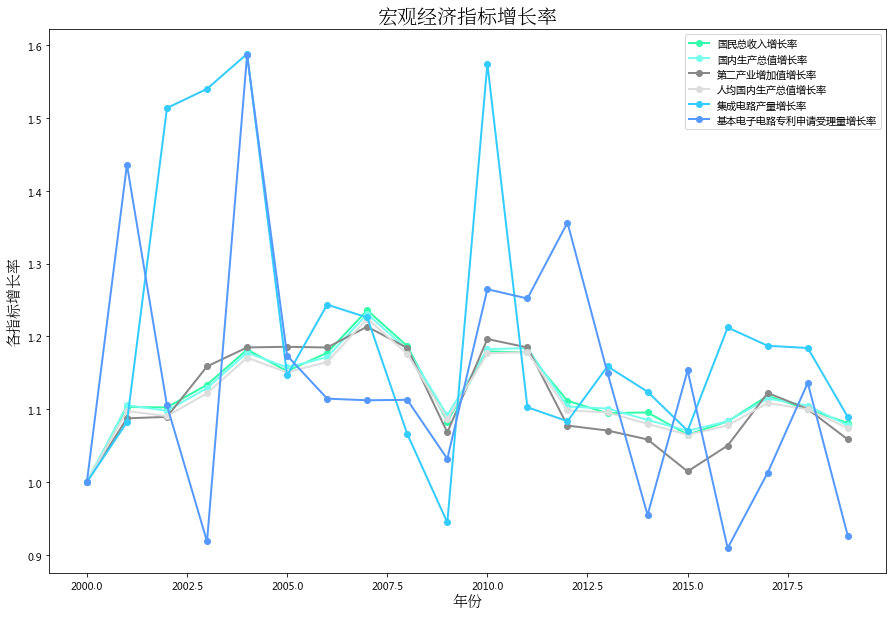

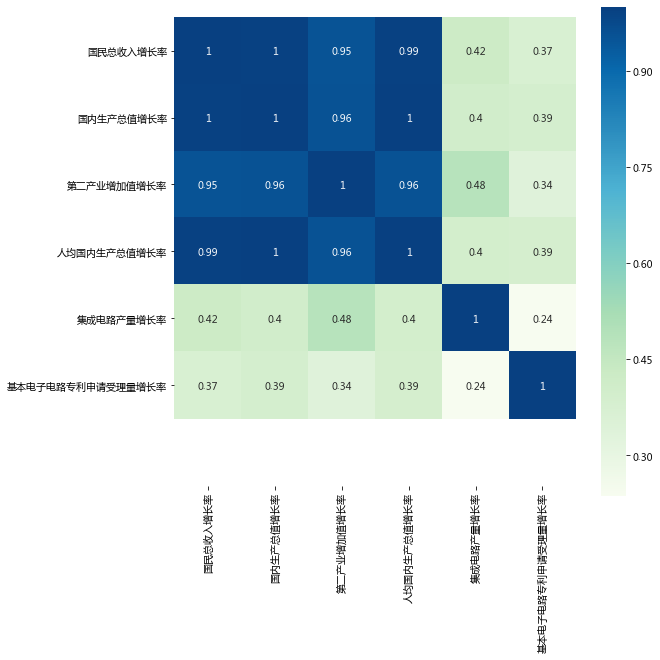

2、集成电路产业政策信息
数据来源：国家工信部官网、国家财政部官网、江苏省工业和信息化厅官网整理的集成电路行业相关政策信息
结合第二部分中企业注册信息、投融资信息的数据，查看波动较大的年份和之前一年分别发布了什么政策。
其中以下几个年份值得重点关注：

2000——2002：行业起步阶段，企业注册数量增加，政策内容偏向规范与资质。
整体而言这段时间是集成电路从0到1的阶段，产业处于偏冷门的位置，政策方向侧重在规范。确定了鼓励产业发展的大方向，做了一些指导性的资质认定和行业规范

2008——2009：财政政策和专项资金加码，融资金额和企业估值增长较大。
国家财政部和税务总局进一步发布企业所得税若干优惠政策，江苏省软件及集成电路专项资金增加到每年2亿元。

2010——2013：行业初步得到国家层面重视，企业注册资本和融资次数增长较大。
国务院牵头工信部和财政部为集成电路产业出台了若干优惠政策，财政方面进行了所得税优，并鼓励促进信息消费扩大内需。工信部成立了服务联盟，印发信息化和工业化深度融合专项行动计划。地方层面江苏也为企业贷款提供了便利。

2015——2016：行业估值腾飞时代，获国家资本与社会资本双双加持。
2014年底财政部设立国家集成电路产业投资基金，次年进一步对集成电路行业进行所得税优惠，国务院在“十三五”规划中重点规划布局。省政府赴各地企业开展调研活动，“爱英之旅”江苏重点软件企业全国校园招聘各地高校举办，吸纳人才。
大基金的成立对于行业来说意义重大，有国家层面的加持，社会资本对于产业关注大幅增加。适逢创业板牛市，多重因素作用下企业的估值增加较快。

2018：自主可控时代，融资金额和企业估值继续增长。
国务院大力支持互联网+，财政部加码税收优惠政策，地方层面无锡和南京举办了博览会。国际层面美国对于芯片的管控加大，运用芯片卡脖子，自主可控迫在眉睫。集成电路大基金一期运作顺利，且浮赢状态良好，创投比以前更愿意投资集成电路行业，行业融资和估值继续增长。
从以上政策信息可以看出，政策层面主要从财政优惠、成立专项基金、人才和学术激励、加强知识产权保护、加强资质认定和管理、举办相关博览会等方式鼓励和指导集成电路行业企业的发展。


3、A股中的集成电路企业数据
数据来源：tushare
用于不同发展阶段集成电路企业的横向对比
与A股集成电路企业的横向对比，可以看出集成电路行业的上市公司中，江苏省注册资本相对较小的企业分布密度大于全国平均值。在全国范围的集成电路企业中，成立于江苏省的占比15.6%，在全国省市中排名第二，表现较好。

In [ ]:
df_listed = pd.read_csv('/home/kesci/input/work1730/集成电路A股数据.csv')
jcdl.loc[jcdl.当前轮次.isin(['上市及以后']) == True, '是否上市'] = True
jcdl.loc[jcdl.当前轮次.isin(['上市及以后']) == False, '是否上市'] = False
#查看江苏省上市公司注册资本
jcdllist = jcdl.loc[jcdl.是否上市 == True]
#A股所有上市公司注册资本
df_listed = df_listed.rename(columns={'reg_capital':'上市公司注册资本'})
plt.figure(figsize=(10,5))
sns.kdeplot(np.log(df_listed['上市公司注册资本']),color='#00CED1', shade=True,label = '全国') 
sns.kdeplot(np.log(jcdllist['注册资本']), color='#99BBFF',shade=True,label = '江苏省') 
plt.legend()
plt.title(u'集成电路行业江苏省和全国上市公司注册资本分布情况',fontproperties=font_set,fontsize='20')
plt.xlabel(u'注册资本（对数）,单位：万元',fontproperties=font_set,fontsize='15')
plt.ylabel(u'企业数量',fontproperties=font_set,fontsize='15',)

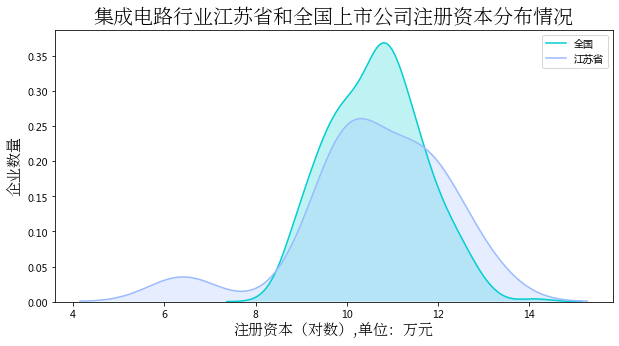

In [ ]:
shengfen_listed = df_listed.groupby(df_listed.province).fullname.count()
ssdict = {'省份':shengfen_listed.index,'数量':shengfen_listed.values}
df_ss = pd.DataFrame(ssdict)
df_ss.loc[df_ss.省份.isin(['江苏', '浙江','广东','上海','北京']) == False, '省份'] = '其他'
shengfen_listed = df_ss.groupby(df_ss.省份).数量.sum()
shengfen_listed
plt.figure(figsize=(6,6))
plt.pie(shengfen_listed,startangle = 90,labels =list(shengfen_listed.index),
        colors = ['#CCFF99','#99FF33','#33FFAA','#77FFEE','#33CCFF','#CCEEFF'],autopct='%.3f%%',
        pctdistance=0.7,labeldistance=0.9,textprops= {'fontsize':12,'color':'black'},counterclock = False);
plt.title('集成电路上市公司中主要省份占比',fontsize='15')


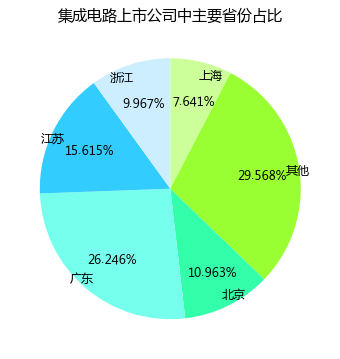

四、活力指数的设计、评定和可视化展示
1、按年度
以2000年为起始值(若2000年没有数据则用1999和2001平均值)，并按季节调整得到2020年的预估数据，计算以下参数的相对增涨率，综合计算出当年度的活力指数。

注册指数：

新增企业数量
新增企业注册资本(万元)总额
投资指数：

新增投融资交易次数
新增投融资交易金额(万元)总额
估值指数：

企业融资的平均新增融资额(万元)
企业的平均估值(万元)
创新创业活力指数：三个指数归一化后取平均

In [ ]:
df_tz_jcdl.交易时间 = pd.to_datetime(df_tz_jcdl.交易时间)
df_tz_jcdl.index = pd.DatetimeIndex(df_tz_jcdl.交易时间)
# 计算 2000年基数
gs_2000 = jcdl[jcdl.index.year == 2000 ].企业名称.count()
zb_2000 = jcdl[jcdl.index.year == 2000 ].注册资本.sum()
tz_2000 = df_tz_jcdl[df_tz_jcdl.index.year == 2000 ]['总交易金额 (万元)'].sum()
# 分组年度技术企业数量，注册资本数量
df_zhishu = jcdl.groupby(jcdl.index.year).agg({'企业名称':['count'], '注册资本':['sum']})
# 将年度投资额度合并到指数数据集
# 将 年度 设为索引列
df_zhishu['时间'] = df_zhishu.index
# 2000之后的数据
df_zhishu =  df_zhishu.loc[(df_zhishu.时间 >=2000)]
# 重命名列名
df_zhishu.columns = ['企业数量','注册资本','时间']

season_df = jcdl[(jcdl['成立时间'] >='2015-01-01 00:00:00') & (jcdl['成立时间'] <= '2019-12-31 00:00:00')]
season_df['month'] = season_df.index.month
#此项调整2020年的数据，根据季节指标推算出全年的
season = season_df.groupby(season_df.month)['企业名称'].count()
season = season / sum(season)
df_zhishu['企业数量'].values[-1] = df_zhishu['企业数量'].values[-1]/sum(season[0:3])
season1 = season_df.groupby(season_df.month)['注册资本'].sum()
season1 = season1 / sum(season1)
df_zhishu['注册资本'].values[-1] = df_zhishu['注册资本'].values[-1]/sum(season1[0:3])
# 计算注册指数: 企业数量+ 注册资本
df_zhishu['注册指数']= df_zhishu.apply( lambda x: 0.5* x['企业数量']/gs_2000 + 0.5* x['注册资本']/zb_2000  ,axis=1)

#fig = plt.figure(figsize=(15,5))
#plt.plot(df_zhishu['时间'],df_zhishu['注册指数'],color='#00CED1',marker='o',linewidth=2,label='注册指数')
#plt.ylabel(u'注册指数',fontproperties=font_set,fontsize='15')
#plt.title(u'注册指数：企业数量+注册资本',fontproperties=font_set,fontsize='20')
# 按年度查看交易金额和交易次数
# 按年度对比交易总金额
#以2000年为基准，那么有一个问题是只有1999和2001的，把这两个做算数平均
df_tz_jcdl['计数'] = 1
#因为有一部分数据交易金额和估值缺失，但这并不是没有意义的，可能存在年份数据丢失，需要单独计算数量
tz_num = df_tz_jcdl.groupby(df_tz_jcdl.index.year)['计数'].sum()
tz_num_dict = {'time':tz_num.index,'count':tz_num.values}
start_num = (tz_num_dict['count'][0] + tz_num_dict['count'][1]) / 2
#起始的融资数量1999年1家，2001年2家，所以2000年的基数start_num定为1.5家。
#相同的方式处理融资金额
jiaoyijine = df_tz_jcdl.groupby(df_tz_jcdl.index.year)['总交易金额 (万元)'].sum()
jydict = {'time':jiaoyijine.index,'jyjine':jiaoyijine.values}
start_amount = (jydict['jyjine'][0] + jydict['jyjine'][1]) / 2

season_df1 = df_tz_jcdl[(df_tz_jcdl['交易时间'] >='2015-01-01 00:00:00') & (df_tz_jcdl['交易时间'] <= '2019-12-31 00:00:00')]
t_month = lambda x: x[5:7]
season_df1['month'] = season_df1.index.month
season_index = season_df1.groupby(season_df1.month)['总交易金额 (万元)'].sum()
season_index = season_index / sum(season_index)
#近5年来投资活动的季节性影响，可以看到9月份的投资最活跃，年底是投资金额较小
#此项调整2020年的数据，根据季节指标推算出全年的
jiaoyijine.values[-1] = jiaoyijine.values[-1] / sum(season_index[0:3])
#对交易次数同样处理
season_index1 = season_df1.groupby(season_df1.month)['计数'].sum()
season_index1 = season_index1 / sum(season_index1)
tz_num.values[-1] = tz_num.values[-1]/sum(season_index1[0:3])

#融资数量和融资金额显然都是有意义的，但他们的意义并不是相同的，一个海天味业抵得上N家酿造厂。
#定为数量占权30%，金额占权70%。
#验证得知两个数据的年份没有出现不同的情况
index_numpart = tz_num / start_num
index_amountpart = jiaoyijine / start_amount
index_tz = 0.3*index_numpart  + 0.7*index_amountpart 


tzdict = {'时间':index_tz.index,'投资指数':index_tz.values}
touzizhishu = pd.DataFrame(tzdict)
insertRow = pd.DataFrame([[2000,1.0]],columns=['时间','投资指数'])
above = touzizhishu.loc[:0]
below = touzizhishu.loc[1:]
touzizhishu = above.append(insertRow,ignore_index=True).append(below,ignore_index=True)
touzizhishu = touzizhishu.drop([0])
#fig = plt.figure(figsize=(15,5))
#plt.plot(touzizhishu['时间'],touzizhishu['投资指数'],color='#CCFF99',marker='o',linewidth=2,label='投资指数')
#plt.ylabel(u'投资指数',fontproperties=font_set,fontsize='15')
#plt.title(u'投资指数：投资次数+投资金额',fontproperties=font_set,fontsize='20')
#看看企业平均估值是否有增长，这里必须删除掉没有估值金额的
#企业融资的平均融资额和平均估值是否有上升,以2002年为基数
df_tz_avg = df_tz_jcdl.dropna(subset=['企业估值 (万元)','总交易金额 (万元)'])
tz_avg = df_tz_avg.groupby(df_tz_avg.index.year)['总交易金额 (万元)'].mean()
gz_avg = df_tz_avg.groupby(df_tz_avg.index.year)['企业估值 (万元)'].mean()
tz_avgdict = {'时间':tz_avg.index,'融资金额':tz_avg.values}
df_tz_avg = pd.DataFrame(tz_avgdict)
df_tz_avg.insert(2,'企业估值',list(gz_avg))
# 计算活力指数: 仅计算 企业数量+ 注册资本
tz2002 = df_tz_avg.融资金额[0]
gz2002 = df_tz_avg.企业估值[0]
df_tz_avg['估值指数']= df_tz_avg.apply( lambda x: 0.5* x['融资金额']/tz2002 + 0.5* x['企业估值']/gz2002  ,axis=1)

#fig = plt.figure(figsize=(15,5))
#plt.plot(df_tz_avg['时间'],df_tz_avg['估值指数'],color='#99BBFF',marker='o',linewidth=2,label='注册指数')
#plt.ylabel(u'估值指数',fontproperties=font_set,fontsize='15')
#plt.title(u'估值指数：获投企业平均估值+平均融资额',fontproperties=font_set,fontsize='20')

#可以看到在2008、2009年四万亿的时候，因为资金端宽裕，企业的估值比较高。
#15年创业板牛市以及大众创业万众创新的时候，企业估值也很高
#18年至今是因为贸易战影响，集成电路大基金的运作，自主可控相关的芯片电路企业更受青睐。

#计算创新创业活力指数并用折线图呈现
zhishu = pd.merge(df_zhishu,touzizhishu,on='时间',how='left')
zhishu = pd.merge(zhishu,df_tz_avg,on='时间',how='left')
zhishu = zhishu.fillna(0)
zhishu = zhishu[['时间','注册指数','估值指数','投资指数']]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))
zhishu[['注册指数','估值指数','投资指数']] = scaler.fit_transform(zhishu[['注册指数','估值指数','投资指数']])
zhishu['创新创业活力指数'] = (zhishu.注册指数+zhishu.估值指数+zhishu.投资指数)/3
fig = plt.figure(figsize=(15,7))
plt.title('创新创业活力指数')
plt.plot(zhishu.时间, zhishu.注册指数, color='#DDDDDD', label='注册指数')
plt.plot(zhishu.时间, zhishu.估值指数, color='#99BBFF', label='估值指数')
plt.plot(zhishu.时间, zhishu.投资指数,  color='#CCFF99', label='投资指数')
plt.plot(zhishu.时间, zhishu.创新创业活力指数,marker='*', color='#0066FF', label='创新创业活力指数')
plt.legend() # 显示图例
plt.xlabel('年份')
plt.ylabel('指数')
plt.show()


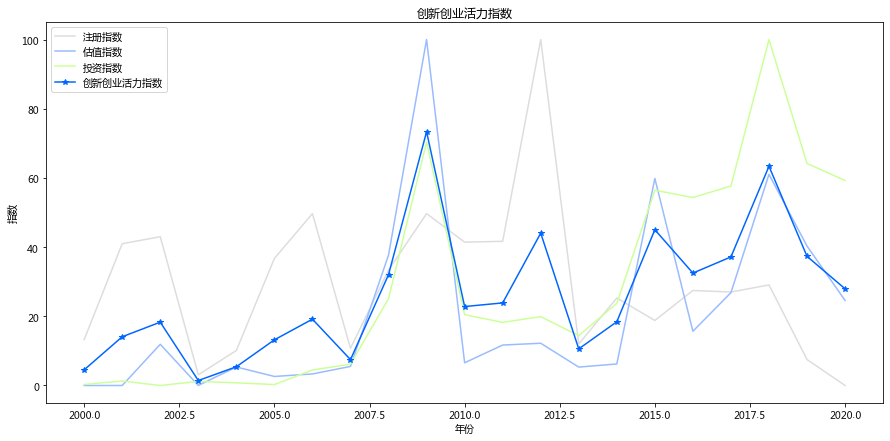

2、按地区
计算各个地区目前的活力指数时，除了上述计算指标，还可以加入知识产权指数、人才指数这些无法从时间维度量化的因素，并做归一化处理，加权平均得到各个地区目前的活力指数，并以地图方式呈现，可以看到苏南地区活跃程度远超苏北，苏州遥遥领先。苏北的徐州市由于企业平均估值和融资金额都比较高，所以在苏北地区表现最好。
（部分地区估值数据缺失较多所以减小权重，企业注册和融资次数更能反映地区活跃度，所以增加权重）

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 10))
#企业注册数量
areacount = jcdlarea.groupby(jcdlarea.市级).企业名称.count()

#企业注册资本总值
zibenarea = jcdlarea.copy()
a1 = zibenarea.drop(index=(zibenarea.loc[(zibenarea.注册资本<1)].index),inplace=False)
arearziben = a1.groupby(a1.市级).注册资本.sum()

#企业平均估值
guzhiarea = jcdlarea.copy()
a2 = guzhiarea.drop(index=(guzhiarea.loc[(guzhiarea.最新估值<1)].index),inplace=False)
areaguzhi = a2.groupby(a2.市级).最新估值.mean()

#企业投资增值
zengarea = jcdlarea.copy()
a3 = zengarea.loc[(zengarea.投资增值>=0)]
areazeng = a3.groupby(a3.市级).投资增值.mean()

#企业知识产权（商标+著作权）总数
arearzhishi = 10*jcdlarea.groupby(jcdlarea.市级).著作权数量.sum()+jcdlarea.groupby(jcdlarea.市级).商标数量.sum()

#融资次数
areatzcount = df_tz_jcdl.groupby(df_tz_jcdl.市级).标的企业全称.count()

#企业总融资金额
areatzvalue1= df_tz_jcdl.groupby(df_tz_jcdl.市级)['总交易金额 (万元)'].sum()

#高管人才指数 
rencaiarea = xueliarea.groupby(xueliarea.市级)['博士以上比例'].mean()+3*xueliarea.groupby(xueliarea.市级)['博士人数'].sum()+2*xueliarea.groupby(xueliarea.市级)['硕士人数'].sum()+xueliarea.groupby(xueliarea.市级)['学士人数'].sum()+5*xueliarea.groupby(xueliarea.市级)['千人计划人数'].sum()+4*xueliarea.groupby(xueliarea.市级)['教授人数'].sum()

dfzhishu = pd.DataFrame(list(zip(areacount,arearziben,areaguzhi,areazeng,arearzhishi,areatzcount,areatzvalue1,rencaiarea)))
dfzhishu = scaler.fit_transform(dfzhishu)
dfzhishu = pd.DataFrame(dfzhishu)
dfzhishu.columns = [['注册数量','平均注册资本','平均估值','投资增值','知识产权','融资次数','总融资金额','高管人才']]
#调整权重
dfzhishu['注册数量'] = 2*dfzhishu['注册数量']
dfzhishu['融资次数'] = 2*dfzhishu['融资次数']
#这部分数据缺失较多所以减小权重
dfzhishu['平均估值'] = 0.5*dfzhishu['平均估值']
dfzhishu['投资增值'] = 0.5*dfzhishu['投资增值']

dfzhishu['创新创业活力指数'] = dfzhishu.apply(lambda x: x.sum(), axis=1)
dfzhishu.insert(0,'市级',areacount.index)
from pyecharts import options as opts
from pyecharts.charts import Map, Page, Timeline, Grid
from pyecharts.charts import Geo, Bar, Line, Gauge, Pie
from pyecharts.globals import ChartType, SymbolType
from pyecharts.globals import ThemeType
state = '创新创业活力指数'

def SetPieces(state): 
    pieces = [
        {"min": 40},
        {"min": 20, "max": 40},
        {"min": 10, "max": 20},
        {"min": 6, "max": 10},
        {"min": 3, "max": 6},
        {"min": 0, "max": 3}]
    return pieces

def SetColorRange(state):
    range_color = ['#CCFF99','#33FFFF','#00CED1','#99BBFF','#5599FF','#0066FF']
    return range_color

data = dfzhishu[['市级','创新创业活力指数']]

# 省份绘图函数
def plot_City(Province,state):
    pieces = SetPieces(state)
    range_color = SetColorRange(state)
    titletext = '江苏各地区创业创新活力指数'
    c = (
        Map()
        .add(state, data.values.tolist(), Province,is_map_symbol_show = True)
        .set_series_opts(label_opts=opts.LabelOpts(is_show=True))
        .set_global_opts(
            title_opts=opts.TitleOpts(title=titletext),
            visualmap_opts=opts.VisualMapOpts(max_=15000, is_piecewise=True,pieces=pieces,
            range_color=SetColorRange(state)),
        )
        )
    return c
MAP = plot_City('江苏','创新创业活力指数')
MAP.render_notebook()

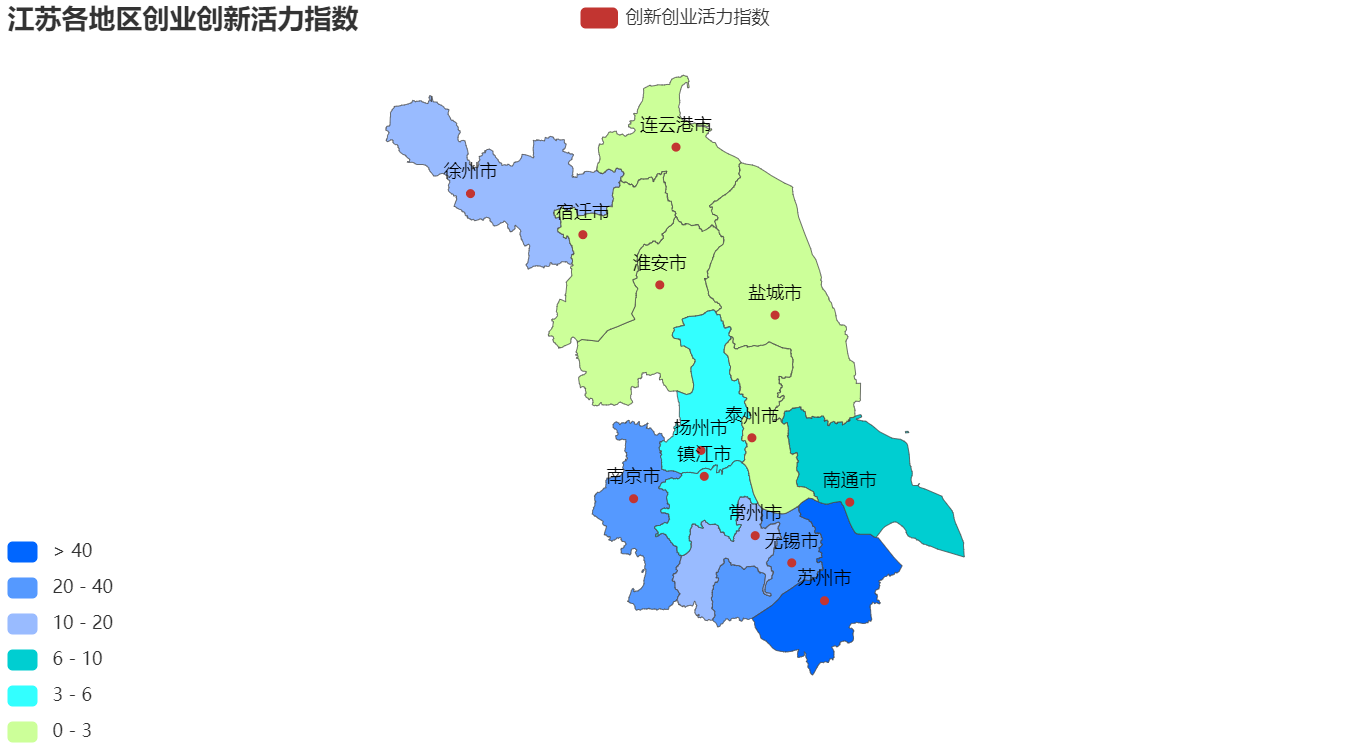

五、影响企业创新创业活力的相关特征和算法
1、按年度测算的活力指数和宏观经济指标的Lasso回归分析
首先查看时间维度上的创新创业活力指数与宏观经济数据之间的相关系数，发现创新创业活力指数与第二产业增加值相关性最大。
因为宏观经济指标之间存在多重共线性，所以用Lasso回归方法筛选变量并做回归，并在之前对变量进行归一化处理。分别验证注册、投资、估值三方面的活力指数与这些宏观经济变量的关系。
系数显示：
注册指数与基本电子电路专利申请受理量增长率呈很弱的正相关关系，与其他宏观经济指标没有显著关系。说明企业注册方面受宏观经济条件影响不大。
投资指数与集成电路产量高度相关，说明企业融资是促进企业发展、提高产出的有效途径。同时与国内生产总值也呈明显正相关关系，说明融资活跃程度受宏观经济条件影响很大。
估值指数与人均国内生产总值呈正相关关系，说明企业发展状况与国民经济水平相关。
而估值指数和投资指数都与集成电路产量增长率呈负相关，是因为集成电路产量基数不断增长导致增长率呈波动趋势，可解释性较弱。
综合分析，我们得到投资指数：即融资活跃程度和金额受宏观经济影响最大。

In [ ]:
zhishu1=zhishu.rename(columns={'时间':'年份'})
zhishu1 = zhishu1.drop(index=(zhishu1.loc[(zhishu1.年份==2020)].index),inplace=False)
huigui = pd.merge(rate,eco,on='年份',how='left')
huigui = pd.merge(huigui,zhishu1,on='年份',how='left')
huigui1 = huigui.drop('年份',axis=1)
correlations = huigui1.corr()['创新创业活力指数'].sort_values()
correlations

huigui1 = scaler.fit_transform(huigui1)
huigui1 = pd.DataFrame(huigui1)
huigui1.columns = huigui.columns[1:]
huigui1['年份']=zhishu1.年份

from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV 
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

X=huigui1.loc[:,('人均国内生产总值(元)', '人均国内生产总值增长率', '国内生产总值(亿元)', '国内生产总值增长率', '国民总收入(亿元)', '国民总收入增长率', '基本电子电路专利申请受理量(项)', '基本电子电路专利申请受理量增长率', '第二产业增加值(亿元)', '第二产业增加值增长率', '集成电路产量(万块)', '集成电路产量增长率')]
#y1=zhishu1.loc[:,'创新创业活力指数']
y2=zhishu1.loc[:,'注册指数']
y3=zhishu1.loc[:,'投资指数']
y4=zhishu1.loc[:,'估值指数']

for i in (y2,y3,y4):
    model = LassoCV()  # LassoCV自动调节alpha可以实现选择最佳的alpha。
    model.fit(X, i)
    feature_cols = ['人均国内生产总值(元)', '人均国内生产总值增长率', '国内生产总值(亿元)', '国内生产总值增长率', '国民总收入(亿元)', '国民总收入增长率', '基本电子电路专利申请受理量(项)', '基本电子电路专利申请受理量增长率', '第二产业增加值(亿元)', '第二产业增加值增长率', '集成电路产量(万块)', '集成电路产量增长率']
    A=list(zip(feature_cols,model.coef_))
    print(A)

2、企业个体活力影响因子重要性分析¶
对于企业个体活力的分析，我们设目标变量为：企业投资增值倍数=（最新估值-最初估值）/最初估值。
用估值增长判断企业发展质量比较可行。
找出企业对应的可量化变量，同xgboost模型做特征重要性排序。
我们得到，影响企业估值增长的最重要特征有经营时间、注册资本、商标数量、获投次数和高管高学历人才数量。

In [ ]:
basic = jcdlarea[['市级','企业名称','注册资本','当前轮次','商标数量','著作权数量','最新估值','注册资本增值','投资增值','年均资本增值','经营时间']]
xueli =pd.merge(xueli[['企业名称','博士人数','硕士人数','学士人数','千人计划人数','教授人数']],basic,on='企业名称',how='outer')
cishu = {'企业名称':qiye_rz.index,'获投次数':qiye_rz .values}
cishu = pd.DataFrame(cishu)
dfnew = pd.merge(xueli,cishu,on='企业名称',how='outer')
dfnew.drop(index=(dfnew.loc[(dfnew['最新估值']==0)].index),inplace=True)
dfnew = dfnew.drop(['企业名称','市级'],axis=1)

train1 = pd.get_dummies(dfnew['当前轮次'])
traindf1= dfnew.drop(['当前轮次'],axis=1,inplace=False)
train = traindf1.join(train1)
train_labels = train['投资增值']

trainx= train.drop(['投资增值'],axis=1,inplace=False)
trainy = train['投资增值']
trainx[:] = trainx[:].astype(float)
trainy[:] = trainy[:].astype(float)

#特征重要性排序
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier()
model.fit(trainx, trainy)
plot_importance(model)
pyplot.show()

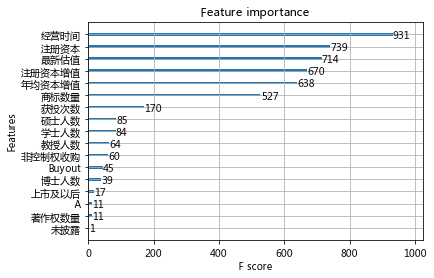

六、从分析结果得出的业务指导与政策建议
江苏省的集成电路产业维持了经济方面南强北弱的格局，对于相对落后的北部地区而言，唯一的竞争优势是土地价格，可以在土地与园区配套设施方面给予集成电路企业优惠，可以承接上海深圳等地不愿忍受高地价企业的产业转移。在引进高科技企业方面，宁德就是一个比较好的例子，用土地吸引了时代新能源，改名宁德时代对于当地起到了非常好的带动作用。当然也需要谨防企业改变土地用途或者拿地不投资生产的情况。

考虑到集成电路产业资金密集型的属性，企业对于资金和创投的需求是刚性的。根据我们上述分析的结论，江苏省集成电路产业最强的市是苏州和无锡，而行业中最活跃的投资机构元禾控股和无锡创投也恰好位于这两个市，这里面是存在相关性的。从政府扶持产业发展的角度来看，应当建立好企业与创投机构之间的桥梁，多组织企业和创投机构进行联合路演，尽力为企业的资金需求服务。

我们注意到发展指数受到股市以及其他的经济事件影响程度比较大，一些好的年份企业可以在市场中融到足够的资金，但是到了波谷可能资金层面就相对紧张，一些技术优良的企业也可能因为产品研发周期问题陷入困境，在平时可以多了解企业的基本情况，对于企业的质地有摸底的情况。如果财政资金有余力允许，可以按照市场化的方法成立集成电路产业基金或者纾困基金，如果企业有资金需求，可以按照市场化的情况进行纾困或者投资，在扶持产业发展的情况下实现国有资产保值增值。

集成电路是技术资本双密集的产业，对于高校层面可以增加相关的科研基金，在生源方面适当扩招，工程师红利也是我国的核心竞争力之一。高校可以引进国外相关人才，对于校内教授进行集成电路相关产业的创业予以支持，在职位与股权方面灵活处理。大力促进产学研相结合。